## Panel Data Regression Analysis as a Determinant of Archipelago Tourism Travel in Indonesia

By: Firmanda Wahyunita

# Methodology

![Screenshot 2024-11-17 211219.png](<attachment:Screenshot 2024-11-17 211219.png>)
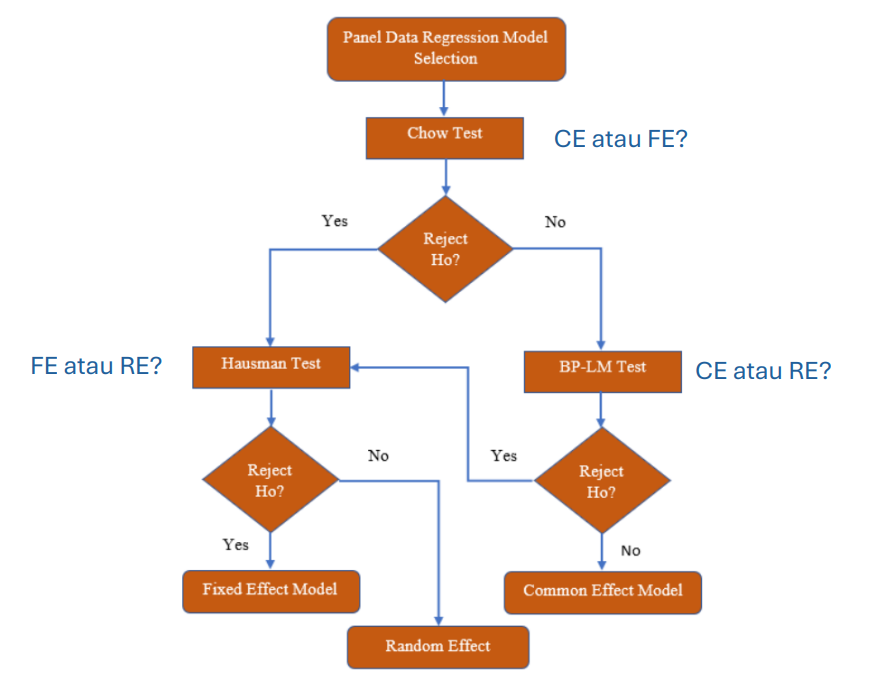

# Library

In [1]:
import pandas as pd
import numpy as np
from scipy import stats 
from linearmodels.panel import PooledOLS, PanelOLS, RandomEffects
from linearmodels.panel import compare
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS, add_constant
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from scipy.stats import f
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load Data

In [2]:
dataset = pd.read_excel("D:/Semester 5/Ekonometrika/tugas/data/Jumlah Wisata Nusantara.xlsx")
dataset = dataset.set_index(['Provinsi', 'Tahun'])

X = dataset[['Daya_Tarik_Wisata_Alam', 'Daya_Tarik_Wisata_Budaya', 'Daya_Tarik_Wisata_Buatan', 
                   'Taman_Hiburan_dan_Rekreasi', 'Kawasan_Pariwisata', 'Wisata_Tirta']]
y = dataset['Jumlah_Wisnus']
X = add_constant(X)


# Chow-Test

In [3]:
# Pooled OLS Model (Common Effect)
common_model = PooledOLS(y, X)
common_results = common_model.fit()

# Fixed Effects Model (within transformation)
fixed_model = PanelOLS(y, X, entity_effects=True)
fixed_results = fixed_model.fit()

# Chow Test calculation
# Combine residuals for both models
e_common = common_results.resids
e_fixed = fixed_results.resids

n = len(dataset)
k = len(X.columns)
SSR_common = np.sum(e_common**2) 
SSR_fixed = np.sum(e_fixed**2) 

chow_stat = ((SSR_common - SSR_fixed) / k) / (SSR_fixed / (n - k))
p_value = 1 - stats.f.cdf(chow_stat, k, n - k)
print("Chow Test Statistic: ", chow_stat)
print("P-value: ", p_value)

# Decision based on p-value
if p_value < 0.05:
    print("Tolak H0: Lakukan Hausman Test")
else:
    print("Gagal Tolak H0: Lakukan BP-LM Test")

Chow Test Statistic:  22.613539825014655
P-value:  9.103828801926284e-15
Tolak H0: Lakukan Hausman Test


The Chow Test results obtained p-value <0.05. This means that the null hypothesis (H0) is rejected, which states that there is no structural difference between the two models. Thus, the analysis continued by conducting the Hausman Test to determine the more appropriate model.

# Uji Hausman

In [4]:
# Hausman Test
random_model = RandomEffects(y, X)
random_results = random_model.fit()

b_fixed = fixed_results.params
b_random = random_results.params

cov_b_fixed = fixed_results.cov
cov_b_random = random_results.cov

# Check for singular covariance matrix
try:
    diff_b = b_fixed - b_random
    cov_diff = cov_b_fixed - cov_b_random
    hausman_stat = diff_b.T @ np.linalg.inv(cov_diff) @ diff_b
    p_value = 1 - stats.chi2.cdf(hausman_stat, len(b_fixed))

    print("Hausman Test Statistic: ", hausman_stat)
    print("P-value: ", p_value)

    if p_value < 0.05:
        print("Tolak H0: Gunakan Fixed Effects Model")
    else:
        print("Gagal Tolak H0: Gunakan Random Effects Model")
except np.linalg.LinAlgError:
    print("Matrix covariance difference is singular. Hausman test tidak dapat dilakukan.")

Hausman Test Statistic:  6.599468563905197
P-value:  0.4717382151586068
Gagal Tolak H0: Gunakan Random Effects Model


The Hausman test results show that the Hausman Statistic is 6.599 with a p-value of 0.471, which is greater than 0.05, so H0 fails to be rejected. This means that the Random Effects Model is more appropriate for the Number of Archipelago Tours data.

# Random Effects Model

In [5]:
# Fit the Random Effects Model
random_model = RandomEffects(y, X)
random_results = random_model.fit()
print(random_results)

                        RandomEffects Estimation Summary                        
Dep. Variable:          Jumlah_Wisnus   R-squared:                        0.8187
Estimator:              RandomEffects   R-squared (Between):              0.8604
No. Observations:                  68   R-squared (Within):               0.7399
Date:                Thu, Nov 28 2024   R-squared (Overall):              0.8379
Time:                        13:43:30   Log-likelihood                   -1165.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      45.919
Entities:                          34   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                    F(6,61)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             45.919
                            

The estimation results using the Random Effects model show that the independent variables are able to explain 81.87% of the variation in the number of domestic tourists (Rsquared Overall: 83.79%). The F test shows that the model is statistically significant with a pvalue of 0.000, indicating a strong relationship between the independent and dependent variables.

# Uji Heteroskedastisitas (RE)

In [6]:
residuals = random_results.resids
bp_test = diag.het_breuschpagan(residuals, X)
bp_p_value = bp_test[1]
print(f"Breusch-Pagan Test p-value: {bp_p_value}")
if bp_p_value < 0.05:
    print("Ada indikasi heteroskedastisitas")
else:
    print("Tidak Ada Indikasi Heteroskedastisitas")

Breusch-Pagan Test p-value: 1.0392216311130486e-05
Ada indikasi heteroskedastisitas


The Breusch-Pagan test results show a p-value of 1.04e-05, which is much smaller than the significance level of 0.05. This indicates a strong indication of heteroscedasticity in the model, i.e. the error variance is not constant. This may affect the validity of the standard error estimates and statistical tests It is necessary to make adjustments, such as using data transformation, to overcome this problem.

# Dataset Transformation Using Log

Log transformation of data aims to address very large scales or non-normal distributions in data, such as the number of tourists or tourist attractions, by reducing large differences between variables. This helps make the relationship between the dependent and independent variables more linear, which is important in regression. In addition, log transformation can reduce the influence of outliers and stabilize the error variance, reducing heteroscedasticity problems.

# Log Transform (RE Model)

In [ ]:
X_log = np.log(X + 1)
y_log = np.log(y + 1)
model_log = RandomEffects(y_log, X_log)
result_log = model_log.fit()

print(result_log)

                        RandomEffects Estimation Summary                        
Dep. Variable:          Jumlah_Wisnus   R-squared:                        0.6871
Estimator:              RandomEffects   R-squared (Between):              0.7131
No. Observations:                  68   R-squared (Within):               0.6513
Date:                Thu, Nov 28 2024   R-squared (Overall):              0.7008
Time:                        13:43:30   Log-likelihood                   -45.573
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      22.322
Entities:                          34   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                    F(6,61)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             22.322
                            

The results of estimating the Random Effects model using log-transformed data show that the model can explain 68.71% of the variation in the number of domestic tourists (R-squared overall = 70.08%). The F-test is significant with a p-value = 0.0000, indicating that the overall model is significant.

# Uji Heteroskedastisitas Setelah Log Transform

In [ ]:
bp_test = diag.het_breuschpagan(result_log.resids, X)
bp_p_value = bp_test[1]
print(f"P-value Uji Breusch-Pagan: {bp_p_value}")
if bp_p_value < 0.05:
    print("Ada indikasi heteroskedastisitas")
else:
    print("Tidak Ada Indikasi Heteroskedastisitas")

P-value Uji Breusch-Pagan: 0.1581243191536857
Tidak Ada Indikasi Heteroskedastisitas


The test results after log transformation show p-value > 0.05,. This indicates that there is no indication of heteroscedasticity in the model, so the assumption of constant error variance (homoscedasticity) is met. Thus, the model estimation results can be considered valid.

# Evaluasi Model

In [9]:
print("\nPengaruh Semua Variabel dalam Model Random Effects (After Log Transform):")
params_rounded = result_log.params.round(5)
pvalues_rounded = result_log.pvalues.round(5)
conf_int = result_log.conf_int()
conf_int_rounded = conf_int.round(4)

summary = pd.DataFrame({
    'Coefficient': params_rounded,
    'P-value': pvalues_rounded,
    'Lower CI': conf_int_rounded.iloc[:, 0],
    'Upper CI': conf_int_rounded.iloc[:, 1],
})
summary



Pengaruh Semua Variabel dalam Model Random Effects (After Log Transform):


,Coefficient,P-value,Lower CI,Upper CI
const,20.34338,0.00000,19.6188,21.0679
Daya_Tarik_Wisata_Alam,0.14048,0.35470,-0.1607,0.4417
Daya_Tarik_Wisata_Budaya,-0.01853,0.90662,-0.3331,0.2960
Daya_Tarik_Wisata_Buatan,0.66702,0.00000,0.4790,0.8551
Taman_Hiburan_dan_Rekreasi,-0.11669,0.42606,-0.4079,0.1745
Kawasan_Pariwisata,0.37095,0.01023,0.0911,0.6508
Wisata_Tirta,-0.04513,0.66518,-0.2526,0.1624


Based on the estimation results of the Random Effects model with Log Transformation, there are two variables that are significant to the number of domestic tourists (log-transformed), namely:
- Daya Tarik Wisata Buatan (p-value = 0.00, coefficient 0.667)
- Kawasan Pariwisata (p-value = 0.0102, coefficient 0.371)

While other variables are not statistically significant (p-value > 0.05)